In [16]:
import numpy as np 
import matplotlib.pyplot as plt
from numba import jit 

In [17]:
# Constants
hbar = 1.055e-34      # Js
q = 1.602e-19         # C
m = 9.1e-31           # kg
m_dot = 0.2 * m       # kg  
bohr_radii = 5.29e-11 # m
a = 1e-10             # m

In [18]:
def VDQD(alpha, x1, x2, x):
    return alpha * min((x - x1) ** 2, (x - x2) ** 2)

def VFT(alpha, F, omega, x1, x2, x, t):
    return alpha * min((x - x1) ** 2, (x - x2) ** 2) + F * x * np.cos(omega * t)

In [19]:
# Constants
Np = 100
X = a * np.linspace(-500, 500, Np) / 1e-9         # nm
dx = (X[1] - X[0]) * 1e-9                         # m
x1 = 10                                           # nm
x2 = -10                                          # nm
alpha = 2.10e-5                                   # eV / nm^2
F = 5e-4                                           # V/m

In [20]:
@jit
def construct_H(U):
    t0 = (hbar * hbar) / (2 * m_dot * dx ** 2) 
    on = 2.0 * t0 * np.ones(Np)
    off = -t0 * np.ones(Np - 1)
    H = np.diag(on + U) + np.diag(off, 1) + np.diag(off, -1)
    return H 

In [21]:
@jit
def compute_eigenvalue_eigenstates(U):
    H = construct_H(U)
    W, V = np.linalg.eig(H)
    idx = W.argsort()[::1]
    W = W[idx]
    V = V[:, idx]
    return W, V

In [22]:
# Finding Initial Condition
U = np.array([VDQD(alpha, x1, x2, x) for x in X])
W, V = compute_eigenvalue_eigenstates(U * q)

In [23]:
omega = (W[1] - W[0]) / hbar
print(f'Energy Gap is {(W[1] - W[0]) * 1e3 / q:.2F} meV')
print(f'Frequency of Oscillation is {omega / (2 * np.pi):.2E}')
print(f'Period of Oscillation is {2 * np.pi / omega:.2E}')

Energy Gap is 1.65 meV
Frequency of Oscillation is 3.98E+11
Period of Oscillation is 2.51E-12


In [24]:
# Constants Derived
Nt = 500
T = np.linspace(0, 2 * np.pi / omega, Nt)           # s (double the period)
dt = T[1] - T[0]                                    # s
gamma = alpha * dt / dx ** 2                        # Check that method is valid for given value of dt and dx
print(f'Gamma = {gamma:.2E}')

Gamma = 1.04E-01


In [25]:
# Set initial psi to be ground state
psi0 = np.array(V[:, 0], dtype='complex_')
psi = np.zeros((Nt, Np), dtype='complex_')
H = construct_H(U * q)

In [26]:
psi_next = psi0
psi[0, :] = psi0

In [27]:
p0 = np.array([np.abs(psi_next @ V[:, 0]) ** 2])
p1 = np.array([np.abs(psi_next @ V[:, 1]) ** 2])

In [28]:
p0, p1

(array([1.]), array([1.54802466e-26]))

In [29]:
for i in range(1, Nt):
    t = T[i]
    U = np.array([VFT(alpha, F, omega, x1, x2, x, t) for x in X])
    H_new = construct_H(U * q)
    A = (1 + 1j * dt / (2 * hbar) * H_new) 
    B = (1 - 1j * dt / (2 * hbar) * H) @ psi_next
    psi_next = np.linalg.solve(A, B)
    _, V = np.linalg.eig(H)
    p0 = np.append(p0, np.abs(psi_next @ V[:, 0]) ** 2) 
    p1 = np.append(p1, np.abs(psi_next @ V[:, 1]) ** 2)
    H = H_new
    psi[i, :] = psi_next
    

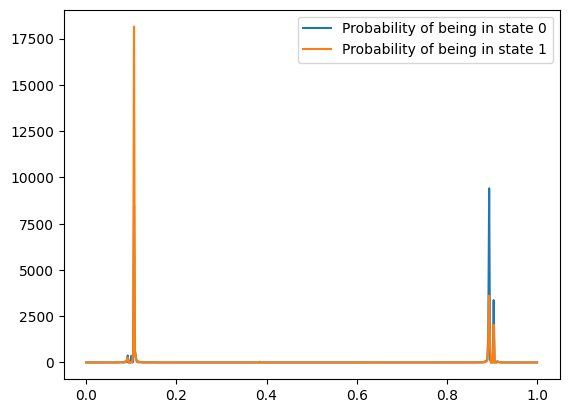

In [30]:
plt.plot(T / (2 * np.pi / omega), p0, '-', label='Probability of being in state 0')
plt.plot(T / (2 * np.pi / omega), p1, '-', label='Probability of being in state 1')
plt.legend()